In [14]:
#basic library for data loading & maths
import numpy as np 
import pandas as pd 

#visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

#image processing library
from collections import Counter
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [52]:
#list to store strings and paths
fruits = []
fruits_image = []

#iterate to load file
for i in os.listdir('/kaggle/input/data-uts-2-0-1/'):
    for image_filename in os.listdir('/kaggle/input/data-uts-2-0-1/' + i):
        fruits.append(i) # name of the fruit 
        fruits_image.append(i + '/' + image_filename) # image of the fruit

In [53]:
#file to df
fruits_df = pd.DataFrame(fruits, columns=["Fruits"])
fruits_df["Fruits Image"] = fruits_image

In [50]:
#check file
fruits_df

,Fruits,Fruits Image
0,cranberry,cranberry/771.jpg
1,cranberry,cranberry/820.jpg
2,cranberry,cranberry/473.jpg
3,cranberry,cranberry/537.jpg
4,cranberry,cranberry/45.jpg
...,...,...
1605,cashew,cashew/1015.jpg
1606,cashew,cashew/454.jpg
1607,cashew,cashew/753.jpg
1608,cashew,cashew/90.jpg


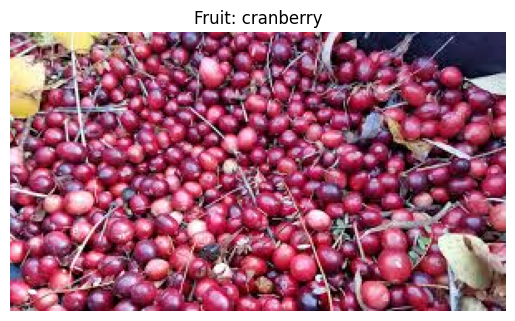

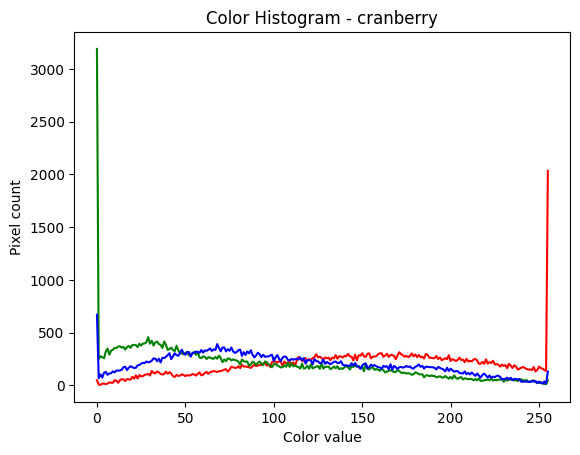

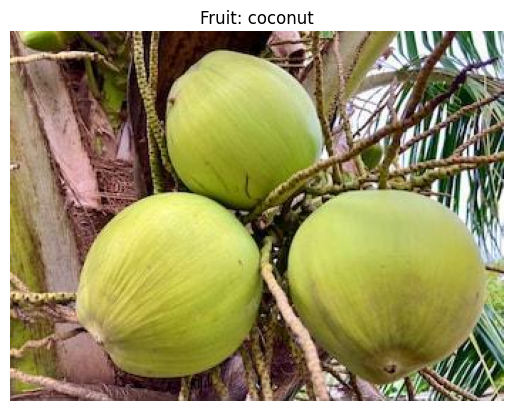

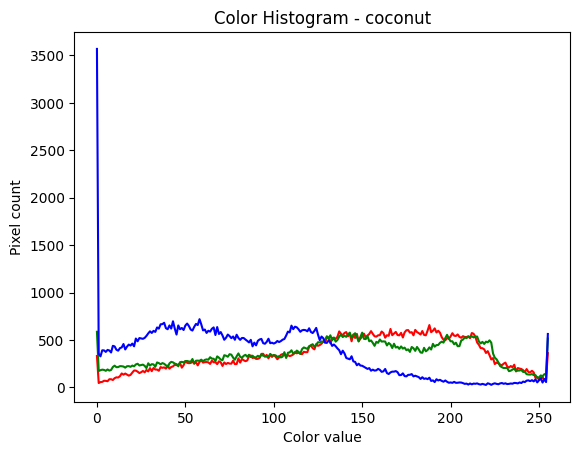

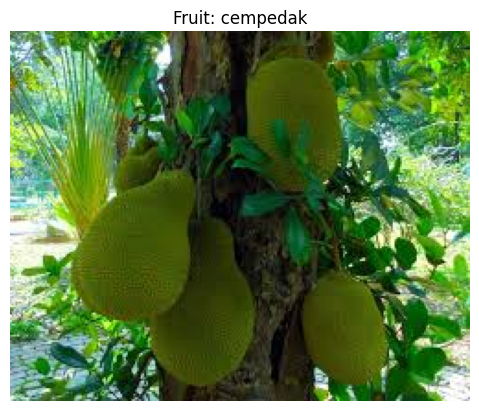

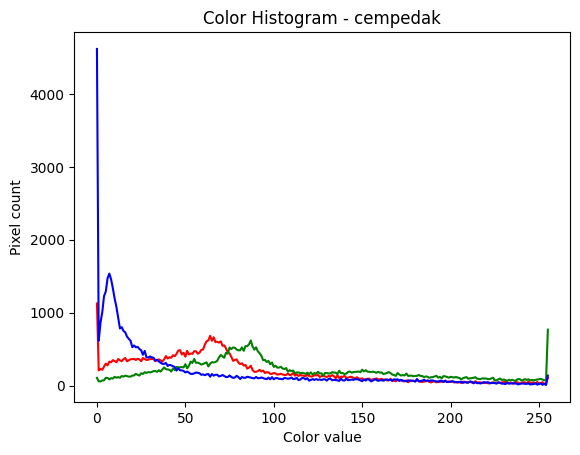

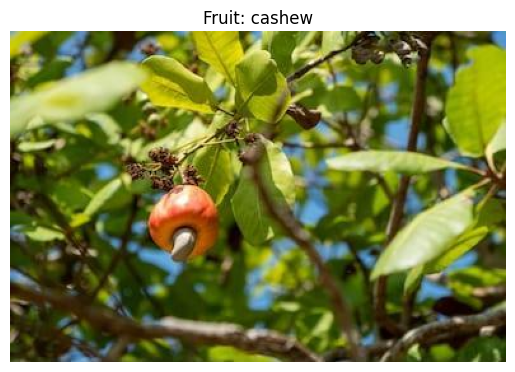

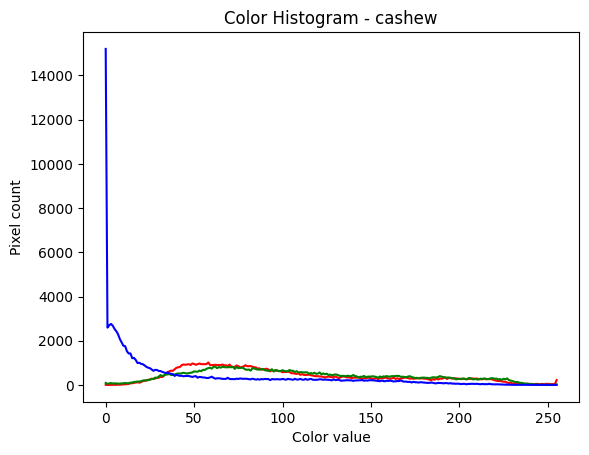

In [64]:
# Calculate color histogram for 1 image per fruit category.
def calculate_color_histogram(image, category):
    # Convert the image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    #select colors of each channel line
    colors = ("red", "green", "blue")
    for channel_id, color in enumerate(colors):
        #histogram for each channel
        histogram, bin_edges = np.histogram(image_rgb[:, :, channel_id], bins=256, range=(0, 256))
        #plot histogram
        plt.plot(bin_edges[0:-1], histogram, color=color)
    
    plt.title(f"Color Histogram - {category}")
    plt.xlabel("Color value")
    plt.ylabel("Pixel count")
    plt.show()

directory = '/kaggle/input/data-uts-2-0-1/'

#keep progress 
processed_categories = set()

#loop to create plots
for fruit_folder in os.listdir(directory):
    if fruit_folder not in processed_categories:
        processed_categories.add(fruit_folder)
        image_filenames = os.listdir(os.path.join(directory, fruit_folder))
        if image_filenames:
            #read image in a category
            image_filename = image_filenames[0]
            image_path = os.path.join(directory, fruit_folder, image_filename)
            image = cv2.imread(image_path)
            
            #show image
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title(f"Fruit: {fruit_folder}")
            plt.axis('off')
            plt.show()
            
            #show histogram
            calculate_color_histogram(image, fruit_folder)

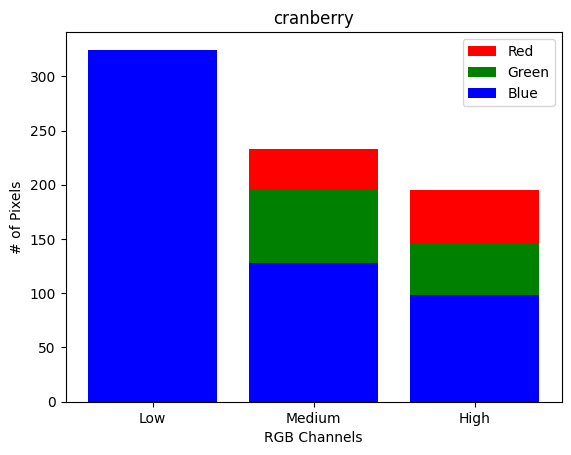

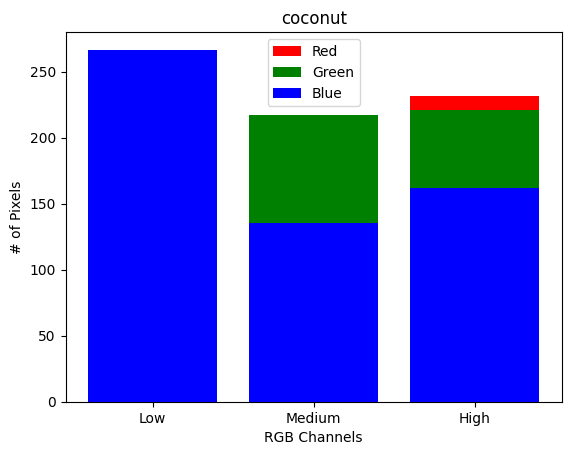

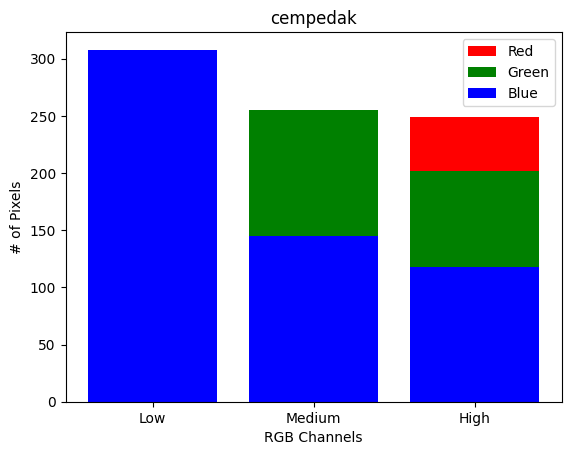

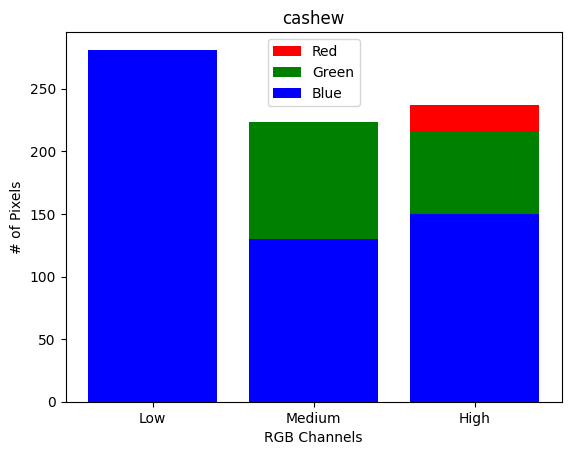

In [62]:
import matplotlib.colors as mcolors  # Importing the mcolors module
# Function to calculate color histogram for a single image
fruits = []
fruits_image = []

# Dictionary to store histograms for each fruit category
histograms = {}

# Loop through the directory to read images and extract their color histograms
for i in os.listdir('/kaggle/input/data-uts-2-0-1/'):
    fruit_hist = np.zeros((3, 3))  # Initialize histogram for each fruit category
    
    for image_filename in os.listdir('/kaggle/input/data-uts-2-0-1/' + i):
        fruits.append(i)  # name of the fruit
        fruits_image.append(i + '/' + image_filename)  # image of the fruit

        # Read the image
        image = cv2.imread('/kaggle/input/data-uts-2-0-1/' + i + '/' + image_filename)
        
        # Convert the image from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Calculate the histograms for each channel separately
        hist_r = cv2.calcHist([image], [0], None, [3], [0, 256])
        hist_g = cv2.calcHist([image], [1], None, [3], [0, 256])
        hist_b = cv2.calcHist([image], [2], None, [3], [0, 256])
        
        # Normalize the histograms for each channel
        hist_r = cv2.normalize(hist_r, hist_r).flatten()
        hist_g = cv2.normalize(hist_g, hist_g).flatten()
        hist_b = cv2.normalize(hist_b, hist_b).flatten()
        
        # Accumulate the histograms for each channel
        fruit_hist[0] += hist_r
        fruit_hist[1] += hist_g
        fruit_hist[2] += hist_b

    # Store the histogram in the dictionary
    histograms[i] = fruit_hist

# Plot histograms for each fruit category
for fruit, hist in histograms.items():
    plt.figure()
    plt.title(fruit)
    plt.xlabel("RGB Channels")
    plt.ylabel("# of Pixels")
    plt.bar(np.arange(3), hist[0], color='red', label='Red')
    plt.bar(np.arange(3), hist[1], color='green',  label='Green')
    plt.bar(np.arange(3), hist[2], color='blue', label='Blue')
    plt.xticks(np.arange(3), ['Low', 'Medium', 'High'])  # Set x-axis labels for RGB channels
    plt.legend()
    plt.show()

#### Blue dominate the lower intensity values for all categories and also appeared in other intensity levels, while cranberry has a red color in both medium and high intensity levels.

In [56]:
fruits_df

,Fruits,Fruits Image
0,cranberry,cranberry/771.jpg
1,cranberry,cranberry/820.jpg
2,cranberry,cranberry/473.jpg
3,cranberry,cranberry/537.jpg
4,cranberry,cranberry/45.jpg
...,...,...
1605,cashew,cashew/1015.jpg
1606,cashew,cashew/454.jpg
1607,cashew,cashew/753.jpg
1608,cashew,cashew/90.jpg


In [60]:
def calculate_background_diversity(image_paths):
    # Load the first image to use as a reference background
    reference_img = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)

    # Initialize an array to store the background diversities
    background_diversities = []

    # Loop through the rest of the images
    for img_path in image_paths[1:]:
        # Load the image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Calculate absolute difference between the reference background and the current image
        diff = cv2.absdiff(reference_img, img)

        # Calculate the diversity score as the mean of the absolute difference
        diversity_score = np.mean(diff)

        # Append the diversity score to the list
        background_diversities.append(diversity_score)

    return background_diversities

def plot_background_diversity(background_diversities):
    # Plot the background diversities
    plt.plot(background_diversities, marker='o')
    plt.xlabel('Image Index')
    plt.ylabel('Background Diversity')
    plt.title('Background Diversity Analysis')
    plt.grid(True)
    plt.show()
    
image_paths = ["image1.jpg", "image2.jpg", "image3.jpg"]  # Replace with your image paths
background_diversities = calculate_background_diversity(image_paths)
plot_background_diversity(background_diversities)

Category: cashew
Resolutions: [(390, 260), (173, 260), (390, 260), (278, 181), (217, 232), (120, 120), (402, 260), (204, 180), (263, 180), (173, 260), (268, 188), (406, 612), (195, 260), (300, 180), (384, 260), (390, 260), (390, 260), (430, 260), (147, 260), (462, 260), (266, 190), (225, 225), (390, 260), (159, 260), (259, 194), (385, 260), (173, 260), (164, 129), (120, 120), (390, 260), (276, 182), (390, 260), (390, 260), (390, 260), (252, 180), (390, 260), (281, 180), (262, 193), (100, 100), (225, 225), (390, 260), (391, 260), (248, 187), (259, 194), (390, 260), (391, 260), (250, 202), (390, 260), (333, 187), (612, 612), (173, 260), (390, 260), (120, 120), (183, 275), (195, 260), (373, 260), (259, 194), (259, 194), (612, 406), (325, 260), (195, 260), (390, 260), (189, 189), (167, 180), (264, 191), (559, 612), (120, 120), (135, 260), (173, 260), (612, 459), (262, 192), (347, 260), (390, 260), (390, 260), (300, 168), (390, 260), (370, 260), (265, 190), (390, 260), (172, 180), (120, 180

In [7]:
# Function to resize the image to 224 x 224
import cv2

# Initialize an empty DataFrame to store resized image paths
resized_fruits = pd.DataFrame(columns=['Fruits', 'Resized Image'])

# Function to resize images
def resize_image(image_path):
    img = cv2.imread('/kaggle/input/data-uts-2-0-1/'+image_path)
    img_resized = cv2.resize(img, (224, 224))
    return img_resized

# Initialize an empty list to store resized images and their corresponding labels
resized_images = []
labels = []

# Iterate through each row in the dataset
for index, row in fruits_df.iterrows():
    original_image_path = row['Fruits Image']  # Assuming the image path is stored in the "Fruits Image" column
    
    # Resize the image
    resized_img = resize_image(original_image_path)
    
    # Append the resized image and its label to the respective lists
    resized_images.append(resized_img)
    labels.append(row['Fruits'])

# Create a new DataFrame to store resized images and their labels
resized_fruits = pd.DataFrame({'Fruits': labels, 'Resized Image': resized_images})

# Display the resized_fruits DataFrame
print(resized_fruits)

         Fruits                                      Resized Image
0     cranberry  [[[130, 126, 138], [119, 113, 124], [157, 148,...
1     cranberry  [[[255, 255, 255], [255, 255, 255], [255, 255,...
2     cranberry  [[[128, 184, 185], [127, 184, 185], [128, 185,...
3     cranberry  [[[69, 72, 26], [69, 72, 26], [69, 72, 26], [6...
4     cranberry  [[[32, 53, 61], [32, 51, 63], [27, 44, 63], [2...
...         ...                                                ...
1605     cashew  [[[21, 20, 26], [18, 20, 23], [10, 20, 18], [5...
1606     cashew  [[[28, 28, 28], [27, 27, 27], [26, 26, 26], [2...
1607     cashew  [[[130, 97, 94], [132, 103, 99], [136, 113, 10...
1608     cashew  [[[0, 115, 14], [0, 112, 11], [0, 108, 5], [0,...
1609     cashew  [[[61, 51, 27], [61, 51, 27], [61, 51, 27], [6...

[1610 rows x 2 columns]


In [18]:
#encode target variable
maps = {
    'cranberry' : 0,
    'cempedak' : 1,
    'coconut' : 2,
    'cashew' : 3
}

y_df = resized_fruits['Fruits']
# Encode y variable using the mapping
encoded_y = [maps[item] for item in y_df]

# Create a new DataFrame with the encoded values
encoded_y_df = pd.DataFrame({'fruits': encoded_y})
encoded_y_df = pd.get_dummies(encoded_y_df['fruits'], dtype = int)

print(encoded_y_df)

      0  1  2  3
0     1  0  0  0
1     1  0  0  0
2     1  0  0  0
3     1  0  0  0
4     1  0  0  0
...  .. .. .. ..
1605  0  0  0  1
1606  0  0  0  1
1607  0  0  0  1
1608  0  0  0  1
1609  0  0  0  1

[1610 rows x 4 columns]


In [20]:
from sklearn.model_selection import train_test_split

x = resized_fruits['Resized Image']

#Splitting into train & test
x_train, x_test, y_train, y_test = train_test_split(x, encoded_y_df, test_size = 0.2, random_state =42)

#Splitting test set into test & validation set
x_valid, x_test, y_valid, y_test = train_test_split(x_test,y_test, test_size = 0.5, random_state =42)

In [21]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_valid = y_valid.astype(int)

In [22]:

def VGG16_baseline(input_shape=(224, 224, 3), num_classes=4000):
    model = Sequential()
    
    # Convolutional layers
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    return model

# Create the model
model = VGG16_baseline()

# Display the model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,276,932 (512.23 MB)

 Trainable params: 134,276,932 (512.23 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
x_train = np.array([np.array(val) for val in x_train])

x_valid = np.array([np.array(val) for val in x_valid])

x_test = np.array([np.array(val) for val in x_test])

# x_test = tf.cast(x_test , dtype=tf.float32)
# y_test = tf.cast(y_test , dtype=tf.float32)

# x_train = tf.cast(x_train , dtype=tf.float32)
# y_train = tf.cast(y_train , dtype=tf.float32)

# x_valid = tf.cast(x_valid , dtype=tf.float32)
# y_valid = tf.cast(y_valid , dtype=tf.float32)

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [112]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['Accuracy'])

# Train the model

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience = 5, restore_best_weights = True, mode = 'max')

history = model.fit(x_train, y_train, 
                    epochs=40, 
                    batch_size=32, 
                    validation_data=(x_valid, y_valid),
                    callbacks=[es])

# Evaluate the model
loss, accuracy = model.evaluate(x_valid, y_valid)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

# Make predictions
predictions = model.predict(x_test)

Epoch 1/40


W0000 00:00:1714350989.288563     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - Accuracy: 0.2516 - loss: 1.3860

W0000 00:00:1714351000.608941     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 328ms/step - Accuracy: 0.2518 - loss: 1.3860 - val_Accuracy: 0.2236 - val_loss: 531119520.0000
Epoch 2/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step - Accuracy: 0.2643 - loss: 1.3861 - val_Accuracy: 0.2236 - val_loss: 512695456.0000
Epoch 3/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - Accuracy: 0.2488 - loss: 1.3866 - val_Accuracy: 0.2236 - val_loss: 544931520.0000
Epoch 4/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - Accuracy: 0.2550 - loss: 1.3859 - val_Accuracy: 0.2236 - val_loss: 538619904.0000
Epoch 5/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - Accuracy: 0.2574 - loss: 1.3865 - val_Accuracy: 0.2236 - val_loss: 539008512.0000
Epoch 6/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - Accuracy: 0.2664 - loss: 1.3855 - val_Accuracy: 0.2236 - val_loss: 524135648.0000
Epoch 7/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - Accuracy: 0.2438 - loss: 1.3864 - val_Accuracy: 0.2236 - val_loss: 547967424.0000
Epoch 8/40
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - Acc

W0000 00:00:1714351279.131137     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [113]:
# Get the index of the maximum value in each row
max_indices = np.argmax(predictions, axis=1)

# Create a new array with all zeros
encoded_arr = np.zeros_like(predictions)

# Set the maximum value in each row to 1
encoded_arr[np.arange(predictions.shape[0]), max_indices] = 1

In [130]:
df = pd.DataFrame(encoded_arr, columns=[0,1,2,3])
df = df.astype(int)
df

,0,1,2,3
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
156,0,0,0,1
157,0,0,0,1
158,0,0,0,1
159,0,0,0,1


In [131]:
# Iterate over each row
for index, row in df.iterrows():
    # Initialize new_column value for the current row
    new_col_value = -1
    
    # Iterate over each column
    for col in df.columns[:-1]:  # Exclude the last column ('new_column')
        if row[col] == 1:
            new_col_value = int(col)
            break  # Break after finding the first occurrence of 1 in the row
            
    # Assign the value to 'new_column' for the current row
    df.at[index, 'new_column'] = new_col_value

# Drop the original columns
df.drop(columns=[0,1, 2, 3], inplace=True)

In [134]:
df = df.abs()
df = df.astype(int)
df

,new_column
0,1
1,3
2,3
3,3
4,3
...,...
156,3
157,3
158,3
159,3


In [35]:
# Iterate over each row
for index, row in y_test.iterrows():
    # Initialize new_column value for the current row
    new_col_value = -1
    
    # Iterate over each column
    for col in y_test.columns[:-1]:  # Exclude the last column ('new_column')
        if row[col] == 1:
            new_col_value = int(col)
            break  # Break after finding the first occurrence of 1 in the row
            
    # Assign the value to 'new_column' for the current row
    y_test.at[index, 'new_column'] = new_col_value

# Drop the original columns
y_test.drop(columns=[0,1, 2, 3], inplace=True)

In [36]:
y_test = y_test.astype(int)
y_test

,new_column
415,2
597,2
887,1
1360,3
1302,3
...,...
514,2
1054,1
619,2
1202,3


In [138]:
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, df, average='macro')
recall = recall_score(y_test, df, average='macro')
f1 = f1_score(y_test, df, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.22360248863697052
Precision: 0.30974842767295596
Recall: 0.25555555555555554
F1 Score: 0.10731626572500554


In [23]:
#reset session to create a new modified model.
tf.keras.backend.clear_session()

In [24]:
from keras.layers import  Dropout, BatchNormalization

def modified_VGG16(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential()
    
    # Convolutional layers
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Create the model
m_model = modified_VGG16()

# Display the model summary
m_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 134,293,828 (512.29 MB)

 Trainable params: 134,285,380 (512.26 MB)

 Non-trainable params: 8,448 (33.00 KB)

In [29]:
# Compile the model
m_model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['Accuracy'])

# Train the model

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience = 10, restore_best_weights = True, mode = 'max')

m_history = m_model.fit(x_train, y_train, 
                    epochs=40, 
                    batch_size=25, 
                    validation_data=(x_valid, y_valid),
                    callbacks=[es])

# Evaluate the model
loss, accuracy = m_model.evaluate(x_valid, y_valid)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

# Make predictions
predictions = m_model.predict(x_test)

Epoch 1/40


W0000 00:00:1714353337.459616    5844 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - Accuracy: 0.3508 - loss: 20.4875

W0000 00:00:1714353362.052687    5843 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714353363.397404    5845 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714353364.297934    5845 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


52/52 ━━━━━━━━━━━━━━━━━━━━ 50s 548ms/step - Accuracy: 0.3504 - loss: 20.3843 - val_Accuracy: 0.2609 - val_loss: 12627.1152
Epoch 2/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step - Accuracy: 0.3306 - loss: 10.4917 - val_Accuracy: 0.2484 - val_loss: 5614.1592
Epoch 3/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step - Accuracy: 0.3320 - loss: 8.7653 - val_Accuracy: 0.3665 - val_loss: 1225.7546
Epoch 4/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step - Accuracy: 0.4099 - loss: 2.7574 - val_Accuracy: 0.4286 - val_loss: 162.8535
Epoch 5/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step - Accuracy: 0.3928 - loss: 2.2898 - val_Accuracy: 0.4224 - val_loss: 64.7807
Epoch 6/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/step - Accuracy: 0.3759 - loss: 2.2503 - val_Accuracy: 0.4224 - val_loss: 25.6366
Epoch 7/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step - Accuracy: 0.3895 - loss: 1.6042 - val_Accuracy: 0.3354 - val_loss: 32.3331
Epoch 8/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step - Accuracy: 0.3635 - loss: 2.0779 - va

W0000 00:00:1714353485.512984    5846 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - Accuracy: 0.2746 - loss: 21054.9414
Validation Loss: 46606.17578125
Validation Accuracy: 0.260869562625885
4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

W0000 00:00:1714353487.480562    5843 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step


In [37]:
#Encode the multilabel prediction into a multiclass prediction so we can do evaluation tests.

# Get the index of the maximum value in each row
max_indices = np.argmax(predictions, axis=1)

# Create a new array with all zeros
encoded_arr = np.zeros_like(predictions)

# Set the maximum value in each row to 1
encoded_arr[np.arange(predictions.shape[0]), max_indices] = 1

df = pd.DataFrame(encoded_arr, columns=[0,1,2,3])
df = df.astype(int)

# Iterate over each row
for index, row in df.iterrows():
    # Initialize new_column value for the current row
    new_col_value = -1
    
    # Iterate over each column
    for col in df.columns[:-1]:  # Exclude the last column ('new_column')
        if row[col] == 1:
            new_col_value = int(col)
            break  # Break after finding the first occurrence of 1 in the row
            
    # Assign the value to 'new_column' for the current row
    df.at[index, 'new_column'] = new_col_value

# Drop the original columns
df.drop(columns=[0,1, 2, 3], inplace=True)

df = df.abs()
df = df.astype(int)
df

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, df, average='macro')
recall = recall_score(y_test, df, average='macro')
f1 = f1_score(y_test, df, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.260869562625885
Precision: 0.11814175211368952
Recall: 0.2202020202020202
F1 Score: 0.14879493464052287


#### our evaluations are improveed generally, F1 Score is increased decently with the new mofied model, which we added dropouts and batch normalizations, proving that our modified model is a success on improving the the prior model's predicting power for the test set. However, i reduced the batch size because the external gpu i used from kaggle returns exhaustion error.